<a href="https://colab.research.google.com/github/jinwu99/Text-mining-and-Sentiment-analysis/blob/main/Sentiment%20Analysis/Movie_review_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


In [ ]:
cd MyDrive/My Drive/Colab Notebooks

/content/MyDrive/My Drive/Colab Notebooks


#가설검증
남한산성 영화의 흥행 실패 요인이 병자호란에 대한 대중의
부정적 인식인가.
* 영화리뷰를 통한 검증.

각 사이트에서의 영화리뷰 데이터 통합

In [ ]:
import pandas as pd

daum = pd.read_csv('Daum_review.csv').dropna(axis=0)
naver = pd.read_csv('Naver_review.csv').dropna(axis=0)
cgv = pd.read_csv('Cgv_review.csv').dropna(axis=0)

In [ ]:
data = pd.concat([daum,naver],ignore_index=True)
data.rename(columns = {'review' : 'document'}, inplace = True)
data.rename(columns = {'user' : 'id'}, inplace = True)

# 5점을 기준으로 긍/부정 나누기.
data['label'] = 1
data.loc[data['rating']<5,'label'] = 0
data['document'] = data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-4-5275ea6f7322>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data['document'] = data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [ ]:
cgv['label2'] = 'Negative'
cgv.loc[cgv['label']==1,'label2'] = 'Positive'
pos_neg_dist = cgv.groupby('label2').size().reset_index()
pos_neg_dist

,label2,0
0,Negative,3844
1,Positive,32303


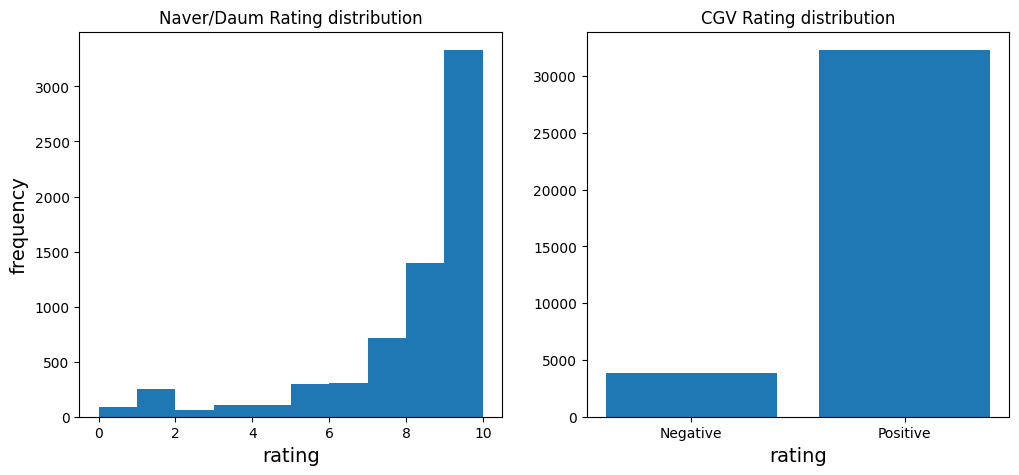

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist(data['rating'],bins=10)
ax[0].set_title('Naver/Daum Rating distribution')
ax[0].set_xlabel('rating',fontdict={'size': 14})
ax[0].set_ylabel('frequency',fontdict={'size': 14})

ax[1].bar(pos_neg_dist['label2'],pos_neg_dist[0])
ax[1].set_title('CGV Rating distribution')
ax[1].set_xlabel('rating',fontdict={'size': 14})
plt.show()
# Selection bias

부정 리뷰 비율(5점 미만)이 낮음. 영화가 흥행하지 못한 점과 상반됨.
선택편향(selection bias)일 가능성이 있음.
* 남한산성 영화는 부정적 역사를 다루기에, 해당 역사에 관심있는 사람들 위주로 관람하고 긍정 리뷰를 썼을 가능성이 있음.
* 역사에 관심있는 사람들의 니즈는 충족했지만, "그 이외의 대중의 니즈"를 충족하지 못했을 가능성이 있음.
    * 각종 뉴스기사에 의하면, "그 이외의 대중의 니즈"는 영화연출과 관련될 가능성이 크다.

가설을 설정하자.
1. 영화리뷰는 역사에 대한 평가와 연출에 대한 평가 등으로 토픽이 나뉠 것이다.
2. 선택편향 경향성이 있다면, 역사에 관심있는 사람들의 평가보다 연출에 대한 평가에서 부정비율이 클것이다.

In [ ]:
data.drop(columns=['rating'],inplace=True)
data = pd.concat([data,cgv],ignore_index=True)

In [ ]:
data.to_csv('daum_naver_cgv.csv',
            index=False,
            encoding='utf-8-sig')

In [ ]:
import pandas as pd

train = pd.read_csv('daum_naver_cgv.csv').dropna(axis=0)
train_list = train['document'].tolist()
train_list[:-10:-1]

['웰메이드 사극이오',
 '혼자서도 주연으로 꽉채울수 있는 배우들이 이렇게나 많이 나오다니 스토리도 영상도 다 정말 잘만들었다고 생각됩니다 추석때 가족과 함께 다시 보러올게요',
 '솔직히 걍 적당히 기대했는데 기대이상 쪽팔린 역사가 감동적이라니 레알 눈물 잘만들었다 진짜',
 '시사회 통해서 봤는데 배우들 연기가 일품',
 '광해군의 중립외교는 재평가되어야함',
 '송파강이 녹고 민들레 꽃이 피었지만 임금은 여전히 남한산성에 있었다',
 '당신은 어떻게 살고 있나요',
 '굴욕의 역사를 잊지를 말자고 하면서도 돼지않는거 같습니다',
 '반복되는 역사 지금도 그때와 비슷하지 않을까']

#데이터분석 계획
1. 유튜브 댓글 분석할때와 비슷하게 클러스터링하자.
2. 그런데 영화리뷰는 유튜브 댓글과 달리  이미 긍정/부정으로 나뉘어져 있음.
3. 영화리뷰 전체를 토픽모델링하고 각 토픽에 따른 긍/부정 비율을 카이제곱검정할 계획
    * 만약 각 토픽이 서로 배타적 관계라면(i.e. 하나의 리뷰에 하나의 토픽만 출현) 토픽모델링 만으로 클러스터링이 가능함.
    * 데이터가 엄청 많은 만큼, p-value는 무조건 낮게 나올 가능성이 있으나 최소한의 검정으로 여기고 size effect를 살펴보자.

In [ ]:
!pip install konlpy # 한국어를 처리하는 대표적인 형태소 분석 패키지

In [ ]:
import numpy as np
from konlpy.tag import *
okt = Okt()

tokenized_doc = [okt.pos(corp, norm=True, stem=True) for corp in train_list]
tokenized_doc = [[word[0] for word in doc if word[1] in ['Noun','Verb','Adjective']] for doc in tokenized_doc]
tokenized_doc = [[n for n in corp if len(n) > 1] for corp in tokenized_doc]

# 불용어 처리
stopwords = ['하다','이다','보다','있다','되다','먹다','같다','많다','야하다',
             '되어다','않다','해주다','있다','없다','이렇다','그렇다','어떻다']
tokenized_doc = [[word for word in corp if not word in stopwords] for corp in tokenized_doc]

np.save('tokenized_morphs_movie_review', np.array(tokenized_doc))

In [ ]:
import numpy as np
tokenized_doc = np.load('tokenized_morphs_movie_review.npy', allow_pickle=True)

## Correlated Topic Model(CTM)
* 토픽간의 상관관계도 함께 측정 가능.
    * 토픽비율을 assign하는 prior distribution을 dirichlet에서 log normal로 바꾸었기에 가능.
    * 양의 방향으로 상관관계가 높은 토픽들은 하나의 리뷰에 같이 등장할 가능성이 큼.
    * 반대로 음의 방향으로 상관관계가 높은 토픽들은 서로 배타적임.

In [ ]:
!pip install tomotopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 22.7 MB/s eta 0:00:00


In [ ]:
import tomotopy as tp

# 먼저 최적의 토픽 수를 구하자.
num_topics_list = range(2, 6)
perplexity_scores = []
coh_sc_u = []
coh_sc_cu = []
coh_sc_cn = []
coh_sc_cv = []

for num_topics in num_topics_list:
    mdl = tp.CTModel(k=num_topics)

    # add docs
    for d in range(train.shape[0]):
        idx = mdl.add_doc(words=tokenized_doc[d])

    # training
    for i in range(0, 100, 10):
        mdl.train(10)

    perplexity_scores.append(mdl.perplexity)
    for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
        coh = tp.coherence.Coherence(mdl, coherence=preset)
        average_coherence = coh.get_score()
        if preset == 'u_mass' : coh_sc_u.append(average_coherence)
        elif preset == 'c_uci' : coh_sc_cu.append(average_coherence)
        elif preset == 'c_npmi' : coh_sc_cn.append(average_coherence)
        elif preset == 'c_v' : coh_sc_cv.append(average_coherence)

Text(0, 0.5, 'Coherence Score')

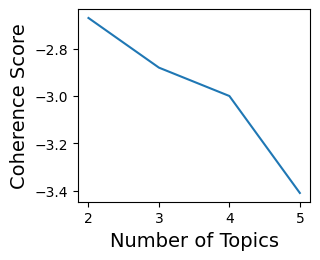

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3,2.5))
plt.plot([2,3,4,5],np.round(coh_sc_u,2))
plt.xlabel('Number of Topics',fontdict={'size': 14})
plt.ylabel('Coherence Score',fontdict={'size': 14})

In [ ]:
# 최적 토픽 갯수는 2개
num_k = 2
removed_idx = [] # 모델객체에 넣을 수 없는 영화리뷰가 있음.
# 그래서 제외되는 리뷰 인덱스를 저장해놓고 긍부정 비율 볼때 활용하려함

mdl = tp.CTModel(k=num_k)
# add docs
for d in range(train.shape[0]):
    idx = mdl.add_doc(words=tokenized_doc[d])
    if idx is None :
        removed_idx.append(d)

# training
for i in range(0, 300, 10):
    mdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

# 파일에 저장
mdl.save('ctm_model.bin')

In [ ]:
# 주제들 간 correlation matrix확인
mdl.get_correlations()

array([[ 1.        , -0.72144574],
       [-0.72144574,  1.        ]], dtype=float32)

In [ ]:
mdl = tp.CTModel.load('ctm_model.bin')

In [ ]:
# Pythohn Plot에 한글 표시하기 위해 한글폰트를 다운받아야함
!apt-get update -qq
!apt-get install fonts-nanum* -qq

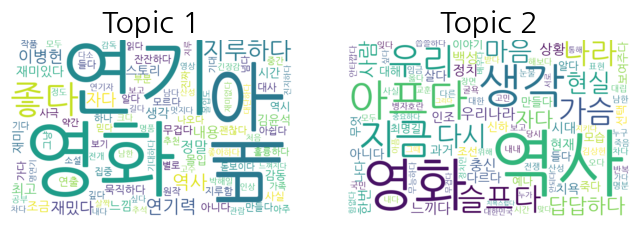

In [ ]:
import matplotlib.font_manager as fm
from wordcloud import WordCloud

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# Plot the word cloud
fig, axs = plt.subplots(1,2,figsize=(8,5))
for topic_id in range(2):
    # Get the top words for the topic
    topic_words = mdl.get_topic_words(topic_id=topic_id,top_n=100)
    wordcloud_dict = {word: prob for word, prob in topic_words}

    # Create the word cloud
    wordcloud = WordCloud(font_path=path, width=800, height=500,
                        background_color='white').generate_from_frequencies(wordcloud_dict)

    axs[topic_id].imshow(wordcloud,interpolation='bilinear')
    axs[topic_id].set_title(f"Topic {topic_id+1}")
    axs[topic_id].axis('off')

Topic 1 : 연출에 대한 평가 \
Topic 2 : 역사에 대한 평가 \
* 두 토픽의 상관관계가 약 -0.72이므로, 서로 배타적임.
* 따라서 각 리뷰를 토픽 비중이 높은 쪽으로 클러스터로 간주 가능.

In [ ]:
mdl.summary()

<Basic Info>
| CTModel (current version: 0.12.5)
| 42583 docs, 304711 words
| Total Vocabs: 11609, Used Vocabs: 11609
| Entropy of words: 6.61425
| Entropy of term-weighted words: 6.61425
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 250, Burn-in steps: 0
| Optimization Interval: 2
| Log-likelihood per word: -7.14470
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 2 (the number of topics between 1 ~ 32767)
| smoothing_alpha: [0.1] (small smoothing value for preventing topic counts to be zero, given as a single `float` in case of symmetric and as a list with length `k` of `float` in case of asymmetric.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 2261828461 (random seed)
| trained in version 0.12.5
|
<Parameters>
| prior_mean (Prior mean of Logit-normal for the per-document topic distribution

In [ ]:
inf_topics = [mdl.infer(mdl.docs[d])[0].argmax() for d in range(42583)]

train = train.reset_index(drop=True)
train = train.drop(removed_idx) # 아까 제외되었던 리뷰들 train에서도 제외
train = train.reset_index(drop=True)
print(train.shape)

train['topic'] = inf_topics
print(train.groupby('topic')['label'].value_counts())

train.to_csv('daum_naver_cgv2.csv', # csv 파일로 저장
             index=False,
             encoding='utf-8-sig')

(42583, 4)
topic  label
0      1        23580
       0         3673
1      1        14594
       0          736
Name: label, dtype: int64


* 연출 토픽에서 부정 비율 : 16%
* 역사 토픽에서 부정 비율 : 5%
* 두 비율이 유의미한 차이를 보이는가 : chi-square p-val < 1e-5

Size effect만 보았을 때도 16%와 5%는 큰 차이. 따라서 역사보다 연출에 대한 부정비율이 크다고 얘기할 수 있으며, 남한산성 영화의 흥행실패 요인을 연출로 볼 수 있음.

##ChatGPT활용한 세부내용 파악
* 각 클러스터별로 텍스트를 복사하여 ChatGPT로 내용 요약요청.
    *  총 4개의 클러스터 : 연출긍정, 연출부정, 역사긍정, 역사부정.
* 자세한 과정은 Youtube_comment_analysis를 참조.

In [ ]:
!pip install transformers

from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

tokenizer = PreTrainedTokenizerFast.from_pretrained('gogamza/kobart-summarization')
model = BartForConditionalGeneration.from_pretrained('gogamza/kobart-summarization')

In [ ]:
import torch

def BART_summary(tokenizer,model,text_lst,intv,max_len):
    summary_texts = ''
    for k in range(round(len(text_lst)/intv)+1):
        print('from ',0+k*intv,' to ',(k+1)*intv)
        input_ids = tokenizer.encode(' '.join(text_lst[(0+k*intv):((k+1)*intv)]))
        input_ids = [tokenizer.bos_token_id] + input_ids + [tokenizer.eos_token_id]
        input_ids = torch.tensor([input_ids])
        try:
            summary_ids = model.generate(input_ids,  num_beams=4,  max_length=max_len,  eos_token_id=1)
        except:
            print('exception occured at ', 0+k*intv,' to ',(k+1)*intv)
            continue
        summary_texts += tokenizer.decode(summary_ids.squeeze().tolist(), skip_special_tokens=True) + ' '
    return summary_texts

In [ ]:
import re

train = pd.read_csv('daum_naver_cgv2.csv').dropna(axis=0)

train_t1l0 = train.loc[(train['topic']==1) & (train['label']==0),].reset_index(drop=True)
train_t0l0 = train.loc[(train['topic']==0) & (train['label']==0),].reset_index(drop=True)
train_t1l1 = train.loc[(train['topic']==1) & (train['label']==1),].reset_index(drop=True)
train_t0l1 = train.loc[(train['topic']==0) & (train['label']==1),].reset_index(drop=True)

train_t1l0 = train_t1l0['document'].tolist()
train_t0l0 = train_t0l0['document'].tolist()
train_t1l1 = train_t1l1['document'].tolist()
train_t0l1 = train_t0l1['document'].tolist()

In [ ]:
train_t1l0_summary = [BART_summary(tokenizer,model,train_t1l0,10,10)]
train_t0l0_summary = [BART_summary(tokenizer,model,train_t0l0,10,10)]
train_t1l1_summary = [BART_summary(tokenizer,model,train_t1l1,10,10)]
train_t0l1_summary = [BART_summary(tokenizer,model,train_t0l1,10,10)]

np.save('train_t1l0_summary', np.array(train_t1l0_summary))
np.save('train_t0l0_summary', np.array(train_t0l0_summary))
np.save('train_t1l1_summary', np.array(train_t1l1_summary))
np.save('train_t0l1_summary', np.array(train_t0l1_summary))

In [ ]:
train_t1l0_chatgpt = ['먼저, 영화가 병자호란과 조선시대 역사를 왜곡하거나 미화하여 다룬다는 점이 지적되며, 주요 사건들이 실제 역사와 달리 처리되어 현실적인 내용이 약화되었다는 비판이 나타납니다. 또한 주연 배우인 이병헌과 김윤석의 연기를 높이 평가하는 반면, 이들의 연기가 역사적 사실과 다소 떨어진다는 지적도 나오고 있습니다. 더불어 영화의 정치적 시각과 의도에 대한 의문이 제기되며, 영화가 조선시대 역사를 특정한 정치적 시각으로 왜곡하거나 강조하려 한다는 비판도 보입니다. 이러한 부정적인 시각들 중에서도 가장 주목할 만한 주제는 역사적 왜곡과 미화로, 이로 인해 영화가 역사 교육에도 나쁜 영향을 미칠 수 있다는 우려가 나타나고 있습니다.']
train_t0l0_chatgpt = ['첫째, 영화의 흥미로움과 재미 부족이 지적되었습니다. 영화 내용이 지루하다는 평이 많이 나오며, 역사적 사실이나 내용은 나쁘지 않다고 하나 영화로서의 재미가 부족하다는 느낌이 강합니다. 특히 전체적으로 영화가 불필요한 장면을 많이 보여준다는 의견이 보입니다. 둘째, 영화의 내용과 전개에 대한 비판이 많이 나타납니다. 스토리가 지루하고 단조로워 보이며, 영화의 전개가 느린 템포로 진행된다는 평가가 있습니다. 또한 영화의 픽션 인물의 삽입이나 연출 등도 부족하다는 느낌을 받았다는 리뷰도 있습니다. 셋째, 배우들의 연기에 대한 평가는 대체로 긍정적이지만, 이 역시도 영화의 전체적인 만족도에 큰 영향을 미치지 못했다는 의견이 많습니다. 이병헌과 김윤석의 연기는 좋았으나 영화의 스토리나 전개가 너무 느립니다. 어떤 리뷰어들은 영화의 긴 러닝타임 동안 그들의 연기만으로는 관객의 흥미를 지속시키기에는 부족하다고 말하며, 연기만으로는 영화의 결점을 커버하지 못했다는 주장도 있습니다.']
train_t1l1_chatgpt = ['첫째, 이 영화는 조선시대의 병자호란 사건을 다루면서, 역사적 사실을 바탕으로 한 강력한 연기와 시각적 표현을 통해 역사적 사건을 현실적으로 다가가게 하고 있습니다. 주연 배우 이병헌과 김윤석의 연기를 통해 역사적 인물들의 감정과 갈등, 그리고 국가의 상황을 잘 보여주며, 이는 시청자들로 하여금 역사의 소중함과 교훈을 다시 한 번 생각하게 합니다. 둘째, 인조와 충신들의 다양한 정치적 입장과 신념을 보여줌으로써, 역사적인 사건의 복잡성과 다양성을 이해할 수 있는 기회를 제공합니다. 인물들 간의 대립과 갈등을 통해 당시의 정치적 현실과 개인의 선택에 대한 이해를 도모하며, 이는 역사적 사건을 단순한 흥미로운 이야기 이상의 교훈적인 내용으로 감상하게 만듭니다. 마지막으로, 이 영화는 우리 역사의 현실과 그 속에서 인조와 충신들이 직면한 어려움, 그리고 그들의 결정을 통해 현재에 대한 생각을 유발합니다. 이를 통해 시청자들은 과거와 현재를 연결하며, 역사의 중요성과 현재에 대한 책임을 다시 한 번 느낄 수 있습니다.']
train_t0l1_chatgpt = ['리뷰들은 김윤석과 이병헌의 연기에 대한 칭찬을 포함하고 있습니다. 김윤석과 이병헌의 앙상블 연기가 특히 언급되며, 이들의 연기력이 영화의 매력을 높였다고 평가하고 있습니다. 또한 이병헌과 김윤석의 대립적인 연기 스타일이 영화에 긴장감과 감동을 더했다는 의견도 나타나고 있습니다. 영화의 사실적인 역사 배경과 묵직한 전쟁 장면, 정통한국사극의 재미 등도 언급되며, 이들 요소가 관객들의 관심을 끌었고 영화를 즐겁게 시청하게 한 요인으로 언급됩니다. 또한 영화가 역사적 사실을 바탕으로 잘 구성되었다는 평가가 보입니다. 영화의 배우진에 대한 호화캐스팅과 연기력, 역사적 사건의 표현, 정통 사극의 웰메이드한 제작 등이 리뷰들에 긍정적으로 언급되고 있습니다. 영화가 가족들과 함께 즐겁게 감상할 수 있는 영화로 평가되고 있으며, 추석 등의 명절기간에 가족들과 함께 보기에 적합하다는 의견도 포함되어 있습니다.']

np.save('train_t1l0_chatgpt', np.array(train_t1l0_chatgpt))
np.save('train_t0l0_chatgpt', np.array(train_t0l0_chatgpt))
np.save('train_t1l1_chatgpt', np.array(train_t1l1_chatgpt))
np.save('train_t0l1_chatgpt', np.array(train_t0l1_chatgpt))

연출긍정 : 배우 연기와 극적 표현에서 뛰어난 연출. \
연출부정 : 영화전개가 지루함. \
역사긍정 : 역사를 돌아보아 현재를 돌아보게함. \
역사부정 : 실제 역사와의 괴리에서 비판.

###각 역사 인물에 대한 평가
* 역사긍정과 역사부정 클러스터에서 남한산성 대표 인물인 '인조', '최명길', '김상헌'을 언급한 댓글들만 추출하여 세부내용 파악

In [ ]:
import numpy as np

Kim_Choi_pos_review = list(set([doc for doc in train_t1l1 if '최명길' in doc or '김상헌' in doc]))
Kim_Choi_neg_review = list(set([doc for doc in train_t1l0 if '최명길' in doc or '김상헌' in doc]))
In_Jo_pos_review = list(set([doc for doc in train_t1l1 if '인조' in doc]))
In_Jo_neg_review = list(set([doc for doc in train_t1l0 if '인조' in doc]))

print(len(' '.join(Kim_Choi_neg_review)),
      len(' '.join(Kim_Choi_pos_review)),
      len(' '.join(In_Jo_neg_review)),
      len(' '.join(In_Jo_pos_review)))

3660 35271 4229 35560


In [ ]:
Kim_Choi_pos_summary = [BART_summary(tokenizer,model,Kim_Choi_pos_review,10,10)]
In_Jo_pos_summary = [BART_summary(tokenizer,model,In_Jo_pos_review,10,10)]

np.save('Kim_Choi_pos_summary', np.array(Kim_Choi_pos_summary))
np.save('In_Jo_pos_summary', np.array(In_Jo_pos_summary))

In [ ]:
Kim_Choi_neg_chatgpt = ['김상헌: 영화에서 김상헌의 캐릭터에 대한 평가는 대부분 부정적인 것으로 보입니다. 김상헌은 영화 속에서 역사적 사실과는 다른 방식으로 묘사되었으며, 그의 역할로 인해 역사 왜곡이 발생했다는 비판이 많습니다. 김상헌은 할복자살을 감독한 인물로 묘사되었는데, 이것이 사실과 다르다는 지적이 많습니다. 이러한 왜곡은 무리한 연출과 비현실적인 표현으로 이어지며, 역사의 복잡한 맥락과 깊은 감정을 반영하지 못하였다는 지적이 있습니다. 김상헌의 인물을 일방적으로 비판하고 조롱하는 톤으로 그의 캐릭터를 표현한 것으로 보이며, 이로 인해 관객들은 김상헌에 대한 부정적인 감정을 품을 수 있습니다. 최명길: 영화에서도 최명길의 캐릭터에 대한 평가는 크게 긍정적이지 않습니다. 최명길은 영화 내에서 역사적 사실과는 다른 방식으로 표현되었고, 그의 의견과 행동에 대한 조작된 묘사가 눈에 띄었습니다. 특히 광해군 몰아내기와 관련된 사건 등에서 최명길의 역할은 크게 왜곡되어 있으며, 이로 인해 그의 실제 역사적 업적과는 거리가 있어 보입니다. 이러한 왜곡은 역사적 사실을 왜곡하고, 관객들에게 오해를 불러일으킬 수 있습니다. 최명길의 캐릭터는 불합리한 행동과 의사 결정으로 묘사되어 있으며, 이로 인해 관객들은 그의 인물에 대한 부정적인 이미지를 갖게 될 수 있습니다.']
Kim_Choi_pos_chatgpt = ['김상헌에 대한 리뷰에서는 그의 연기와 역사적 사건에 대한 묘사, 신념과 행동에 대한 긍정적인 평가가 많이 나타나며, 김상헌의 역할이 조선시대와 병자호란의 역사 속에서 충직하게 나타나고 있다는 인상을 남겼습니다. 또한 그의 자결 장면과 나라를 위해 헌신하는 모습은 감동적으로 묘사되었다고 평가됩니다. 최명길에 대한 리뷰에서는 그가 조선사대부이자 중립외교의 선구자로 평가되며, 그의 신념과 정치적인 주장을 표현한 연기가 높게 평가되었습니다. 또한 병자호란의 역사 속에서 그의 삶과 결정이 감동적으로 다가왔으며, 최명길과 김상헌의 대립이나 갈등은 시대와 사건의 중요성을 감각적으로 전달해주었다는 평가가 많습니다.']
In_Jo_neg_chatgpt = ['이 영화는 역사적 사실을 왜곡하며 인조의 무능함을 지나치게 미화하고 있는 것으로 보입니다. 대부분의 리뷰어들은 영화에서 인조를 부정적으로 평가하며 그의 결정 불능과 권력 내분을 지적하고 있습니다. 또한 영화는 광해군과의 비교를 통해 인조의 무능함과 실존 역사적 사건을 조작하고 있는 것으로 비판되고 있습니다. 이에 따라 영화는 역사왜곡의 수준이라고 평가되며, 인조의 인간적 약점이나 굴욕적인 상황을 제대로 표현하지 못하고 있다는 의견도 있습니다. 인조의 결정과 행동을 바탕으로 한 영화인데도 불구하고 역사적 사실을 왜곡하고 객관적이지 못한 미화를 시도하는 방식으로 제작되어 부정적인 감정과 실망을 불러일으키고 있는 것으로 보입니다.']
In_Jo_pos_chatgpt = ['몇몇 리뷰에서는 인조 왕의 무능한 통치와 답답한 성격에 대한 비판적인 시각이 드러나며, 그의 결정과 행동에 대한 불만과 실망을 표현한 것으로 보입니다. 영화에서는 병자호란과 다양한 갈등 상황에서의 인조의 모습을 보여주며, 이로 인해 관람객들은 인조의 리더십에 대한 의문과 비판을 갖게 되었습니다. 그러나 인조 왕을 긍정적으로 평가하는 의견도 있습니다. 몇몇 리뷰에서는 영화를 통해 인조 왕의 고뇌와 어려움을 표현하고, 그의 결정을 이해하고자 하는 관점을 강조하고 있습니다. 또한 인조의 시대적 배경과 주변 환경을 고려하여 그의 선택이 어려움 가운데에서 이루어진 것임을 감안하며, 그의 힘없는 조선을 이해하려는 노력을 보여주는 리뷰도 있습니다.']

np.save('Kim_Choi_neg_chatgpt', np.array(Kim_Choi_neg_chatgpt))
np.save('Kim_Choi_pos_chatgpt', np.array(Kim_Choi_pos_chatgpt))
np.save('In_Jo_neg_chatgpt', np.array(In_Jo_neg_chatgpt))
np.save('In_Jo_pos_chatgpt', np.array(In_Jo_pos_chatgpt))